# Robotics, Vision & Control 3e: for Python
## Chapter 6: Localization and Mapping

Copyright (c) 2021- Peter Corke

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.display import HTML

import matplotlib.pyplot as plt

# add RTB examples folder to the path
# import sys, os.path
import RVC3 as rvc
# sys.path.append(os.path.join(rvc.__path__[0], 'models'))

# ------ standard imports ------ #
import numpy as np
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import *

In [2]:
V = np.diag([0.02, np.deg2rad(0.5)]) ** 2;

In [3]:
robot = Bicycle(covar=V, animation="car")

Bicycle: x = [ 0, 0, 0 ]
  L=1, steer_max=1.41372, speed_max=inf, accel_max=inf

# 6.4 Simultaneous Localization and Mapping


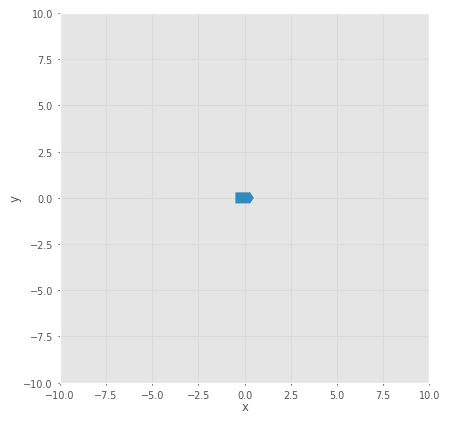

In [4]:
map = LandmarkMap(20, workspace=10);
W = np.diag([0.1, np.deg2rad(1)]) ** 2 
robot = Bicycle(covar=V, x0=(3, 6, np.deg2rad(-45)), 
          animation="car");
robot.control = RandomPath(workspace=map);
W = np.diag([0.1, np.deg2rad(1)]) ** 2
sensor = RangeBearingSensor(robot=robot, map=map, covar=W, 
           range=4, angle=[-pi/2, pi/2]);
P0 = np.diag([0.05, 0.05, np.deg2rad(0.5)]) ** 2;
ekf = EKF(robot=(robot, V), P0=P0, sensor=(sensor, W));

/home/mandel/mambaforge/envs/corke/lib/python3.10/site-packages/roboticstoolbox/mobile/drivers.py:275: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._goal_marker.set_xdata(self._goal[0])


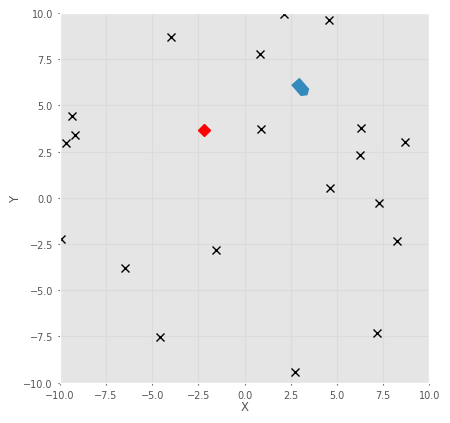

/home/mandel/mambaforge/envs/corke/lib/python3.10/site-packages/roboticstoolbox/mobile/drivers.py:275: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._goal_marker.set_xdata(self._goal[0])


In [5]:
# ekf.run(T=40);

html = ekf.run_animation(T=40, format="html")
HTML(html)

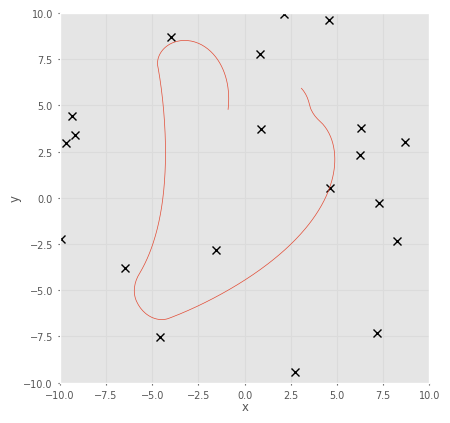

In [15]:
map.plot();       # plot true map
robot.plot_xy();  # plot true path

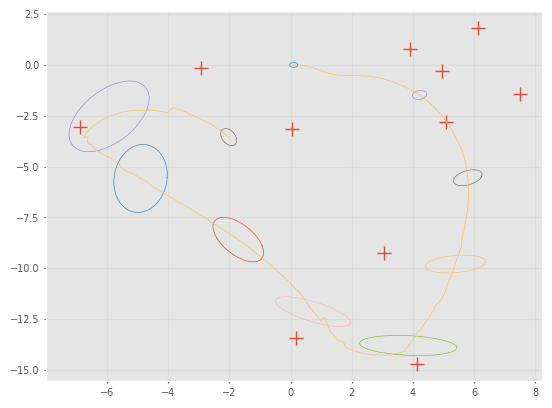

In [18]:
ekf.plot_map();      # plot estimated landmark position
ekf.plot_ellipse();  # plot estimated covariance
ekf.plot_xy();       # plot estimated robot path

In [17]:
T = ekf.get_transform(map)

   0.7088   -0.7054    2.101     
   0.7054    0.7088   -6.315     
   0         0         1         


# 6.5 Pose-Graph SLAM


NOTE. Minor changes to ensure Jupyter pretty printing of SymPy equations.  Introduced underscore to indicate subscripting, and changed `t` to `theta`
which is printed as $\theta$.

In [ ]:
import sympy
xi, yi, ti, xj, yj, tj = sympy.symbols("x_i y_i theta_i x_j y_j theta_j")
xm, ym, tm = sympy.symbols("x_m y_m theta_m")
xi_e = SE2(xm, ym, tm).inv() * SE2(xi, yi, ti).inv() \
     * SE2(xj, yj, tj);
fk = sympy.Matrix(sympy.simplify(xi_e.xyt()));

In [ ]:
Ai = sympy.simplify(fk.jacobian([xi, yi, ti]))
Ai.shape

In [ ]:
Ai

In [ ]:
pg = PoseGraph("data/pg1.g2o");

In [ ]:
pg.plot();

In [ ]:
# pg.optimize(animate=True)

pg.optimize(animate=False)
pg.plot()

In [ ]:
pg = PoseGraph("data/killian-small.toro");

In [ ]:
pg.plot(text=False)

In [ ]:
pg.optimize()
pg.plot(text=False)

# 6.6 Sequential Monte-Carlo Localization


In [ ]:
map = LandmarkMap(20, workspace=10);

In [ ]:
V = np.diag([0.02, np.deg2rad(0.5)]) ** 2;
robot = Bicycle(covar=V, animation="car", workspace=map);
robot.control = RandomPath(workspace=map)

In [ ]:
W = np.diag([0.1, np.deg2rad(1)]) ** 2;
sensor = RangeBearingSensor(robot, map, covar=W, plot=True);

In [ ]:
R = np.diag([0.1, 0.1, np.deg2rad(1)]) ** 2;

In [ ]:
L = np.diag([0.1, 0.1]);

In [ ]:
pf = ParticleFilter(robot, sensor=sensor, R=R, L=L, nparticles=1000, animate=True);

In [ ]:
# pf.run(T=10);

html = pf.run_animation(T=10, format="html");
HTML(html)

In [ ]:
map.plot();
robot.plot_xy();

In [ ]:
pf.plot_xy();

In [ ]:
plt.plot(pf.get_std()[:100,:]);

In [ ]:
pf.plot_pdf()

# 6.8 Application: Lidar


## 6.8.1 Lidar-based Odometry


In [ ]:
pg = PoseGraph("data/killian.g2o.zip", lidar=True);

In [ ]:
[r, theta] = pg.scan(100);
r.shape
theta.shape

In [ ]:
plt.clf()
plt.polar(theta, r);

In [ ]:
p100 = pg.scanxy(100);
p101 = pg.scanxy(100);
p100.shape

In [ ]:
T = pg.scanmatch(100, 101);
T.printline()

In [ ]:
pg.time(101) - pg.time(100)

## 6.8.2 Lidar-based Map Building


In [ ]:
og = OccupancyGrid(workspace=[-100, 250, -100, 250], cellsize=0.1, value=np.int32(0));
pg.scanmap(og, maxrange=40)
og.plot(cmap="gray")